# LinearRegression

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor,HistGradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


## we select the following four features for this task.

In [22]:
# select features we want
features = ['reanalysis_specific_humidity_g_per_kg', 
                'reanalysis_dew_point_temp_k', 
                'station_avg_temp_c', 
                'station_min_temp_c']

Now that we've explored this data, it's time to start modeling. Our first step will be to build a function that does all of the preprocessing we've done above from start to finish. This will make our lives easier, since it needs to be applied to the test set and the traning set before we make our predictions.

In [23]:
def preprocess_data(data_path, features, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2,3])
    
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [24]:
sj_train, iq_train = preprocess_data('./dengue_features_train.csv',
                                    features=features,
                                    labels_path="./dengue_labels_train.csv")

C:\Users\cxf20\AppData\Local\Temp\ipykernel_2968\3271642535.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Now we can take a look at the smaller dataset and see that it's ready to start modelling:

In [25]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.547535,295.104736,26.999191,22.594017,34.180556
std,1.560663,1.570075,1.415079,1.506281,51.381372
min,11.715714,289.642857,22.842857,17.800000,0.000000
25%,15.233571,293.843929,25.842857,21.700000,9.000000
50%,16.835000,295.451429,27.214286,22.800000,19.000000
75%,17.854286,296.415714,28.175000,23.900000,37.000000
max,19.440000,297.795714,30.071429,25.600000,461.000000


In [26]:
sj_train

reanalysis_specific_humidity_g_per_kg  \
year weekofyear week_start_date                                          
1990 18         1990-04-30                                   14.012857   
     19         1990-05-07                                   15.372857   
     20         1990-05-14                                   16.848571   
     21         1990-05-21                                   16.672857   
     22         1990-05-28                                   17.210000   
...                                                                ...   
2008 13         2008-03-25                                   13.644286   
     14         2008-04-01                                   14.662857   
     15         2008-04-08                                   14.184286   
     16         2008-04-15                                   13.858571   
     17         2008-04-22                                   15.671429   

                                 reanalysis_dew_point_temp_k  \
year weekofyear week_start_date                                
1990 18         1990-04-30                        292.414286   
     19         1990-05-07                        293.951429   
     20         1990-05-14                        295.434286   
     21         1990-05-21                        295.310000   
     22         1990-05-28                        295.821429   
...                                                      ...   
2008 13         2008-03-25                        292.095714   
     14         2008-04-01                        293.235714   
     15         2008-04-08                        292.732857   
     16         2008-04-15                        292.274286   
     17         2008-04-22                        294.280000   

                                 station_avg_temp_c  station_min_temp_c  \
year weekofyear week_start_date                                           
1990 18         1990-04-30                25.442857                20.0   
     19         1990-05-07                26.714286                22.2   
     20         1990-05-14                26.714286                22.8   
     21         1990-05-21                27.471429                23.3   
     22         1990-05-28                28.942857                23.9   
...                                             ...                 ...   
2008 13         2008-03-25                25.042857                21.1   
     14         2008-04-01                26.242857                22.2   
     15         2008-04-08                25.000000                21.7   
     16         2008-04-15                25.314286                21.7   
     17         2008-04-22                27.042857                23.3   

                                 total_cases  
year weekofyear week_start_date               
1990 18         1990-04-30                 4  
     19         1990-05-07                 5  
     20         1990-05-14                 4  
     21         1990-05-21                 3  
     22         1990-05-28                 6  
...                                      ...  
2008 13         2008-03-25                 4  
     14         2008-04-01                 3  
     15         2008-04-08                 1  
     16         2008-04-15                 3  
     17         2008-04-22                 5  

[936 rows x 5 columns]

Since this is a timeseries model, we'll use a strict-future holdout set when we are splitting our train set and our test set. We'll keep around three quarters of the original data for training and use the rest to test. We'll do this separately for our San Juan model and for our Iquitos model.

In [27]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [28]:
sj_train_subtest=sj_train_subtest[sj_train_subtest['total_cases']!=0]
iq_train_subtest=iq_train_subtest[iq_train_subtest['total_cases']!=0]

In [29]:
# Extract the parameter columns
X_train = sj_train_subtrain[features]

# Extract the label column
y_train = sj_train_subtrain['total_cases']

# Extract the parameter columns
X_test = sj_train_subtest[features]

# Extract the label column
y_test = sj_train_subtest['total_cases']



In [30]:
X_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c
count,800.000000,800.000000,800.000000,800.000000
mean,16.550268,295.107729,27.019929,22.588500
std,1.555026,1.568636,1.389155,1.517736
min,11.715714,289.642857,22.842857,17.800000
25%,15.257143,293.883929,25.882143,21.700000
50%,16.835000,295.447143,27.257143,22.800000
75%,17.845714,296.400000,28.160714,23.900000
max,19.207143,297.598571,30.071429,25.600000


In [31]:
y_train.describe()

count    800.000000
mean      35.863750
std       54.044483
min        0.000000
25%       10.000000
50%       20.000000
75%       38.000000
max      461.000000
Name: total_cases, dtype: float64

Select fit_intercept as the hyperparameter and return the smallest MAE on the test set

In [32]:
from sklearn.linear_model import Lasso,Ridge
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

In [33]:
def main(X_train, y_train, X_test, y_test):
    # scale
    maes=[]
    mapes=[]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)


    # hyperparameter
    
    max_iters=list(range(1000,10000,1000))
    best_mae = 1000
    best_mape= 1000
    best_pred=1000
    # grid search
    for max_iter in max_iters:
        #  build linear regression model
        model = Ridge(max_iter=max_iter)

        model.fit(X_train, y_train)

        # testing
        y_pred = model.predict(X_test)
        y_pred[y_pred<0] = 0
        y_pred = np.round(y_pred).astype(int)


        print(np.max(y_pred),np.min(y_pred),np.mean(y_pred))
        print(np.max(y_test),np.min(y_test),np.mean(y_test))
        # compute MAE  
        mae = mean_absolute_error(y_test, y_pred) 
        mape = mean_absolute_percentage_error(y_test, y_pred) 
        maes.append([str(max_iter),mae])
        mapes.append([str(max_iter),mape])
        if mae < best_mae:
            best_mae = mae
            best_pred=y_pred
        if mape < best_mape:
            best_mape = mape
    print(f'Best Mean Absolute Error (MAE): {mae}')  
    print(f'Best Mean Absolute PENCENTAGE Error (MAPE): {mape}')
    return maes,mapes,best_mae,best_mape,best_pred

In [34]:
maes,mapes,best_sj_mae_ridge,best_sj_mape_ridge,best_pred=main(X_train, y_train, X_test, y_test)

57 20 35.86666666666667
170 1 24.45925925925926
57 20 35.86666666666667
170 1 24.45925925925926
57 20 35.86666666666667
170 1 24.45925925925926
57 20 35.86666666666667
170 1 24.45925925925926
57 20 35.86666666666667
170 1 24.45925925925926
57 20 35.86666666666667
170 1 24.45925925925926
57 20 35.86666666666667
170 1 24.45925925925926
57 20 35.86666666666667
170 1 24.45925925925926
57 20 35.86666666666667
170 1 24.45925925925926
Best Mean Absolute Error (MAE): 23.037037037037038
Best Mean Absolute PENCENTAGE Error (MAPE): 3.1953752399132935


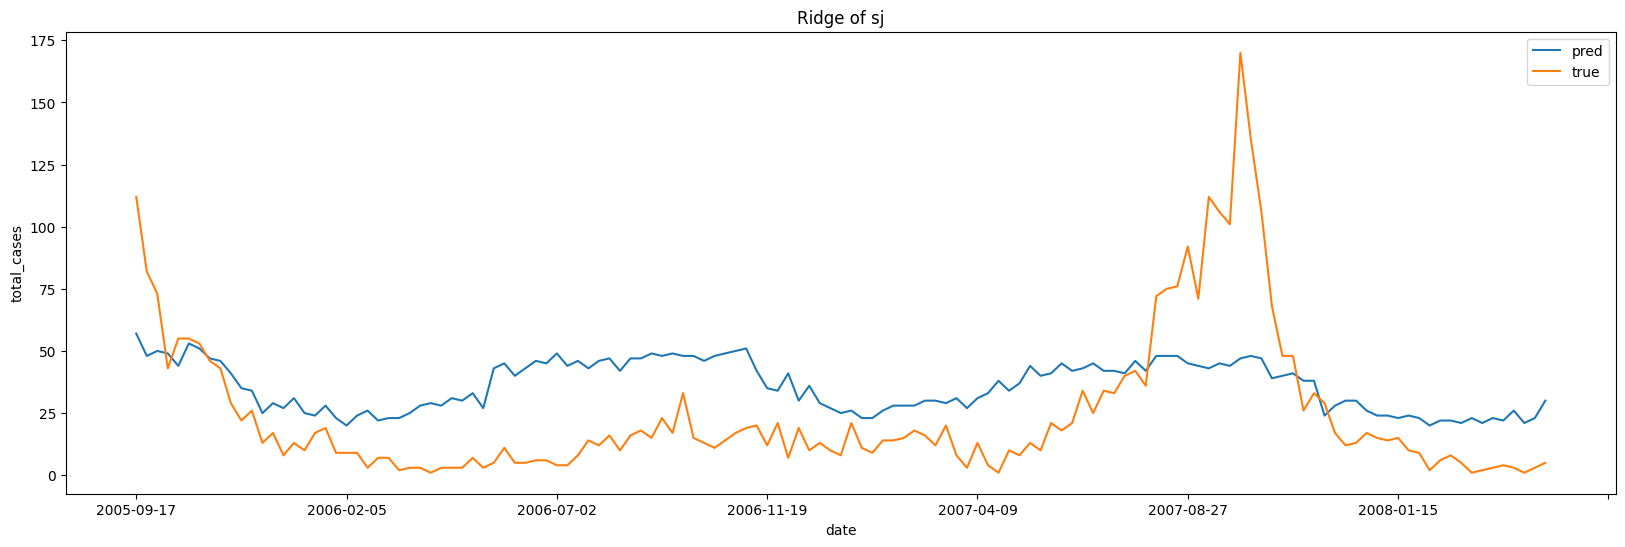

In [35]:
time=[i[2] for i in list(sj_train_subtest.index)]
time_trend=pd.DataFrame()
time_trend['pred']=best_pred
time_trend['true']=list(y_test)
time_trend.index=time
time_trend['pred'].plot(figsize=(20,6))
time_trend['true'].plot(figsize=(20,6))
plt.xlabel('date')
plt.ylabel('total_cases')
plt.title('Ridge of sj')
plt.legend()
plt.show()

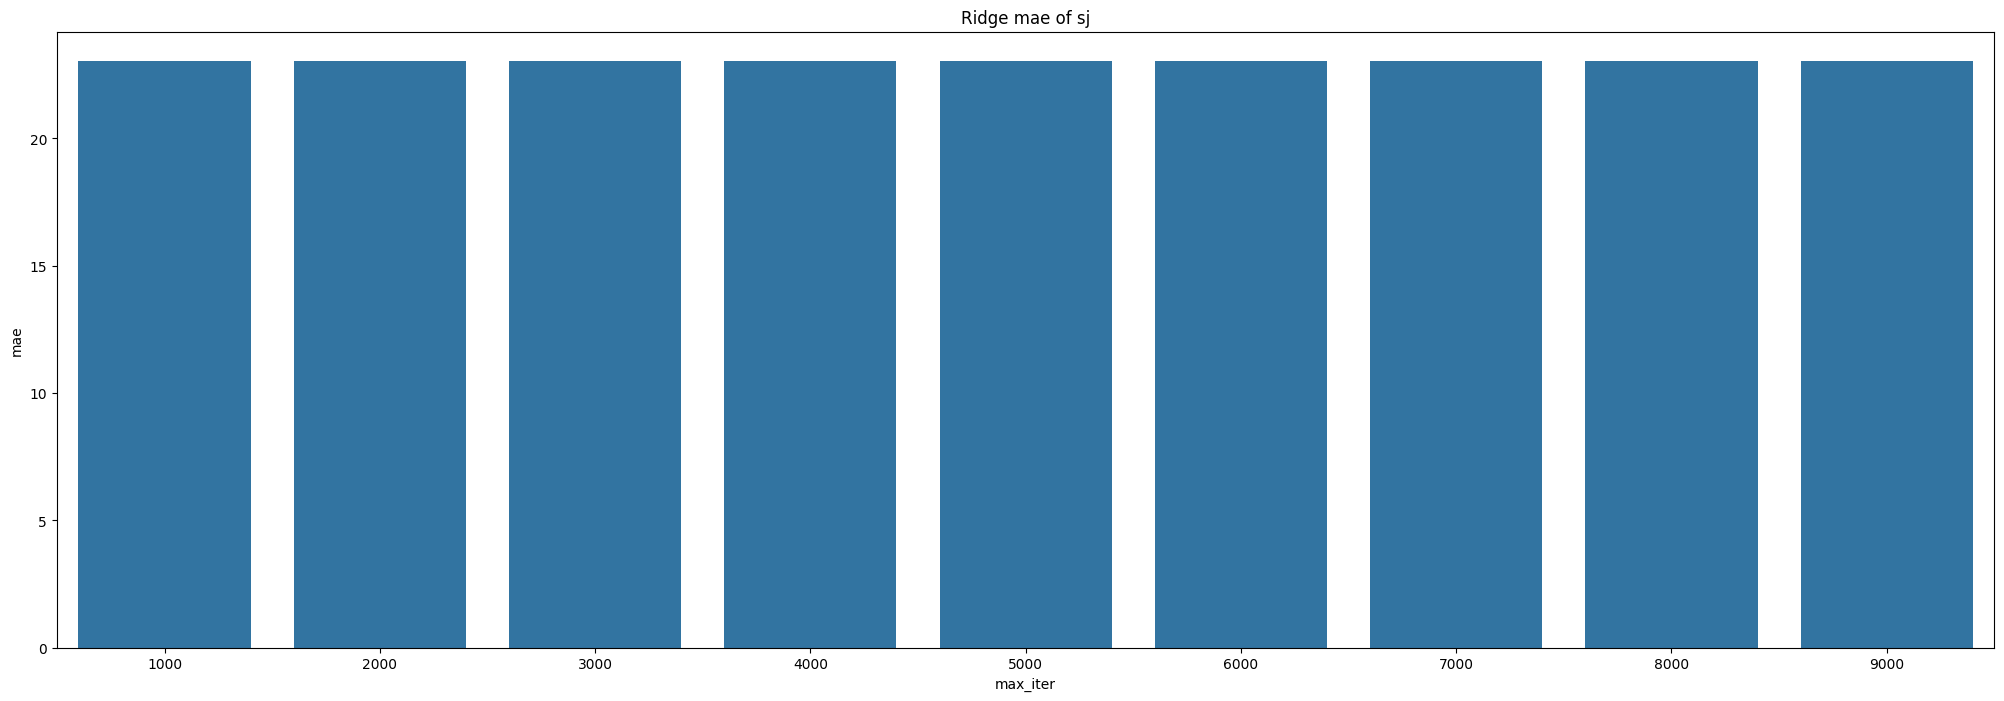

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in maes],y=[i[1] for i in maes])
plt.xlabel('max_iter')
plt.ylabel('mae')
plt.title('Ridge mae of sj')
plt.show()

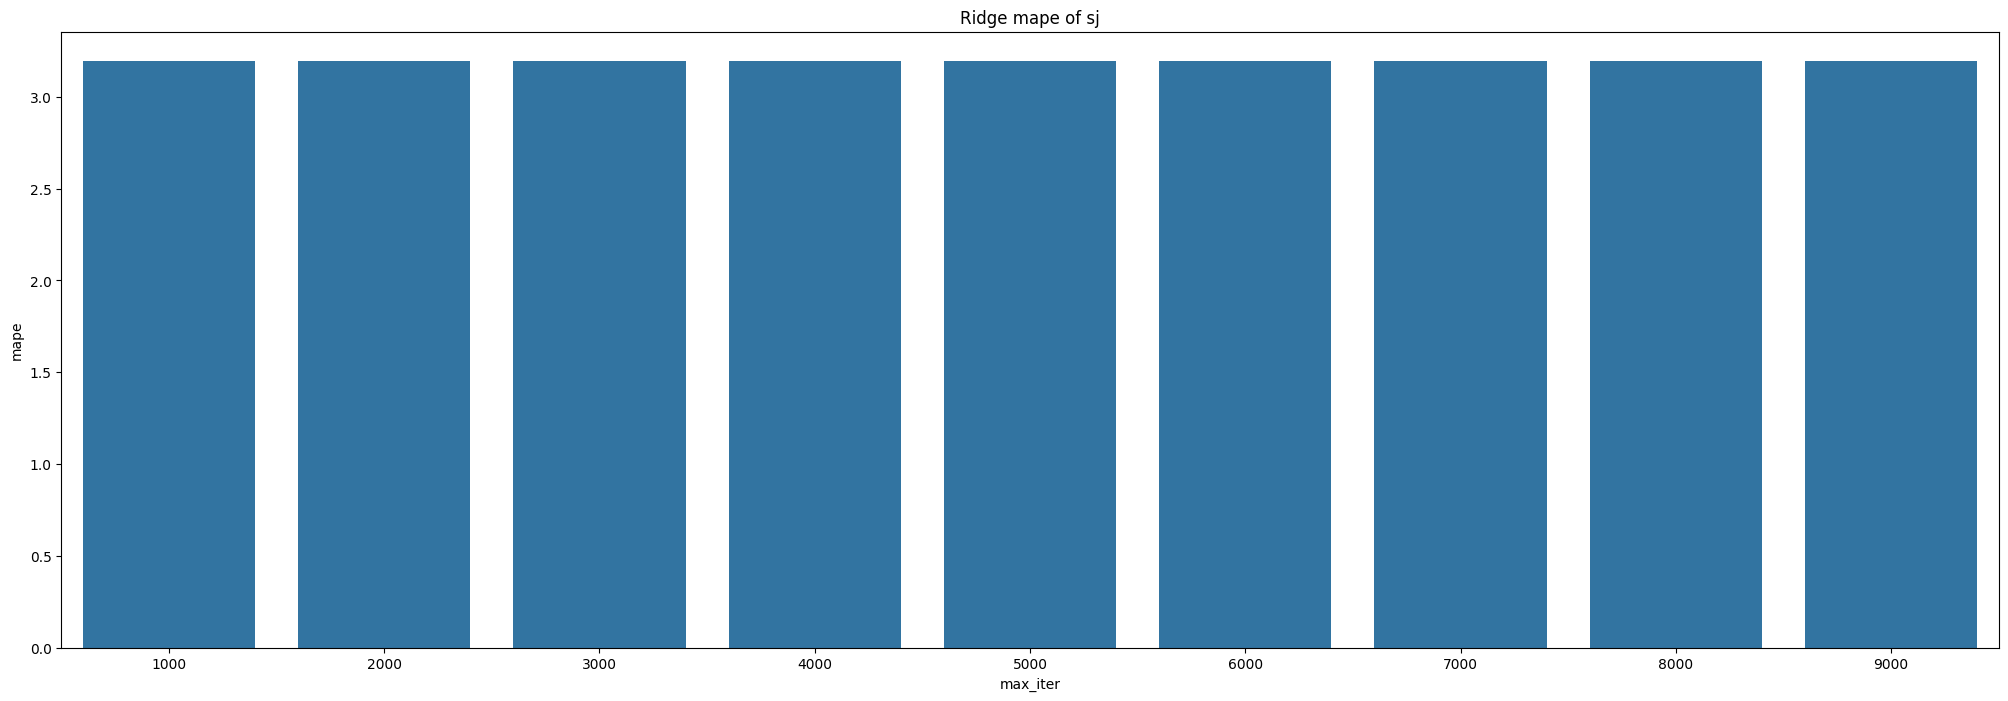

In [37]:
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in mapes],y=[i[1] for i in mapes])
plt.xlabel('max_iter')
plt.ylabel('mape')
plt.title('Ridge mape of sj')
plt.show()

In [38]:
# Extract the parameter columns
X_train = iq_train_subtrain[features]

# Extract the label column
y_train = iq_train_subtrain['total_cases']

# Extract the parameter columns
X_test = iq_train_subtest[features]

# Extract the label column
y_test = iq_train_subtest['total_cases']

In [39]:
maes,mapes,best_iq_mae_ridge,best_iq_mape_ridge,best_pred=main(X_train, y_train, X_test, y_test)

13 0 7.302752293577981
63 1 9.431192660550458
13 0 7.302752293577981
63 1 9.431192660550458
13 0 7.302752293577981
63 1 9.431192660550458
13 0 7.302752293577981
63 1 9.431192660550458
13 0 7.302752293577981
63 1 9.431192660550458
13 0 7.302752293577981
63 1 9.431192660550458
13 0 7.302752293577981
63 1 9.431192660550458
13 0 7.302752293577981
63 1 9.431192660550458
13 0 7.302752293577981
63 1 9.431192660550458
Best Mean Absolute Error (MAE): 6.660550458715596
Best Mean Absolute PENCENTAGE Error (MAPE): 1.4284865680775343


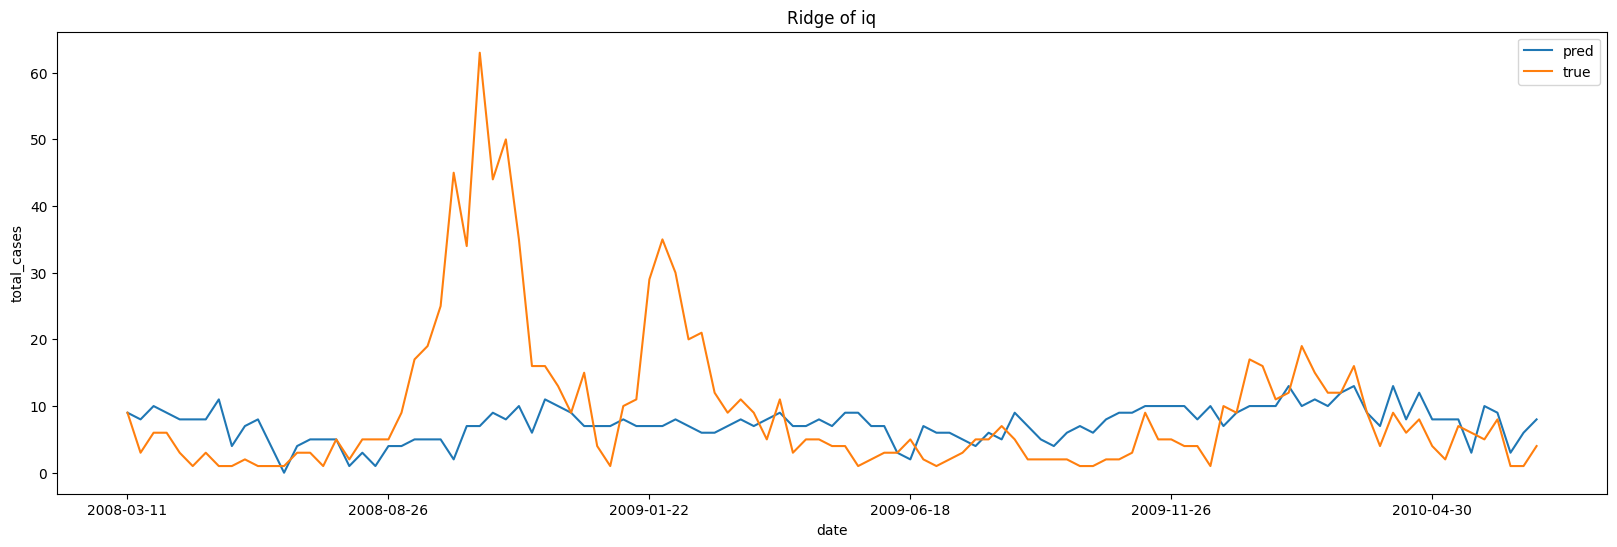

In [40]:
time=[i[2] for i in list(iq_train_subtest.index)]
time_trend=pd.DataFrame()
time_trend['pred']=best_pred
time_trend['true']=list(y_test)
time_trend.index=time
time_trend['pred'].plot(figsize=(20,6))
time_trend['true'].plot(figsize=(20,6))
plt.xlabel('date')
plt.ylabel('total_cases')
plt.title('Ridge of iq')
plt.legend()
plt.show()

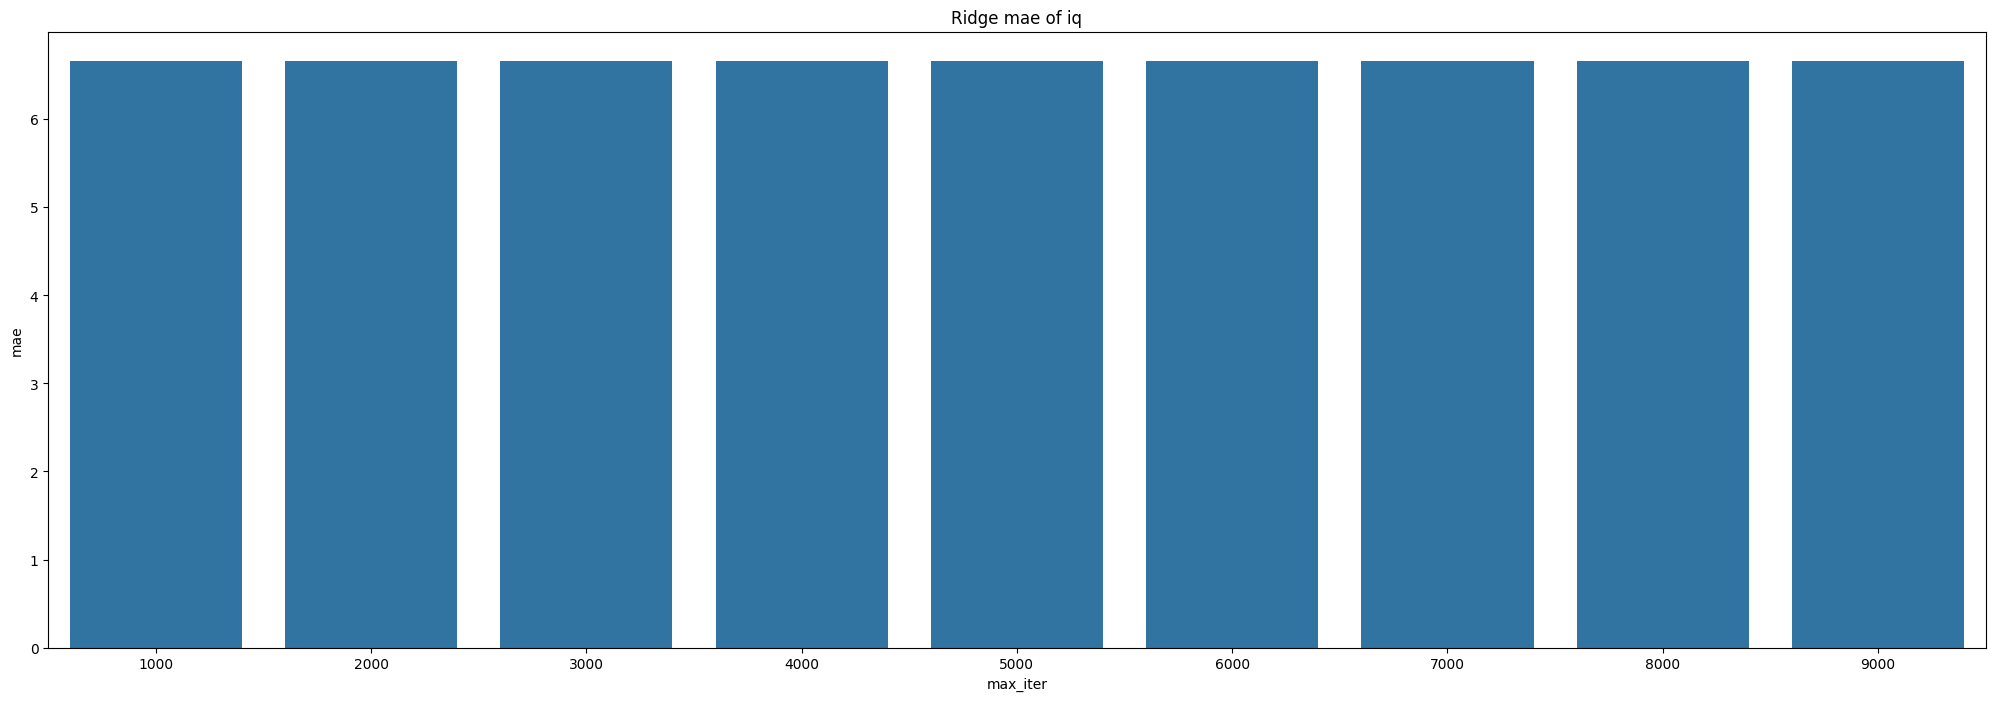

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in maes],y=[i[1] for i in maes])
plt.xlabel('max_iter')
plt.ylabel('mae')
plt.title('Ridge mae of iq')
plt.show()

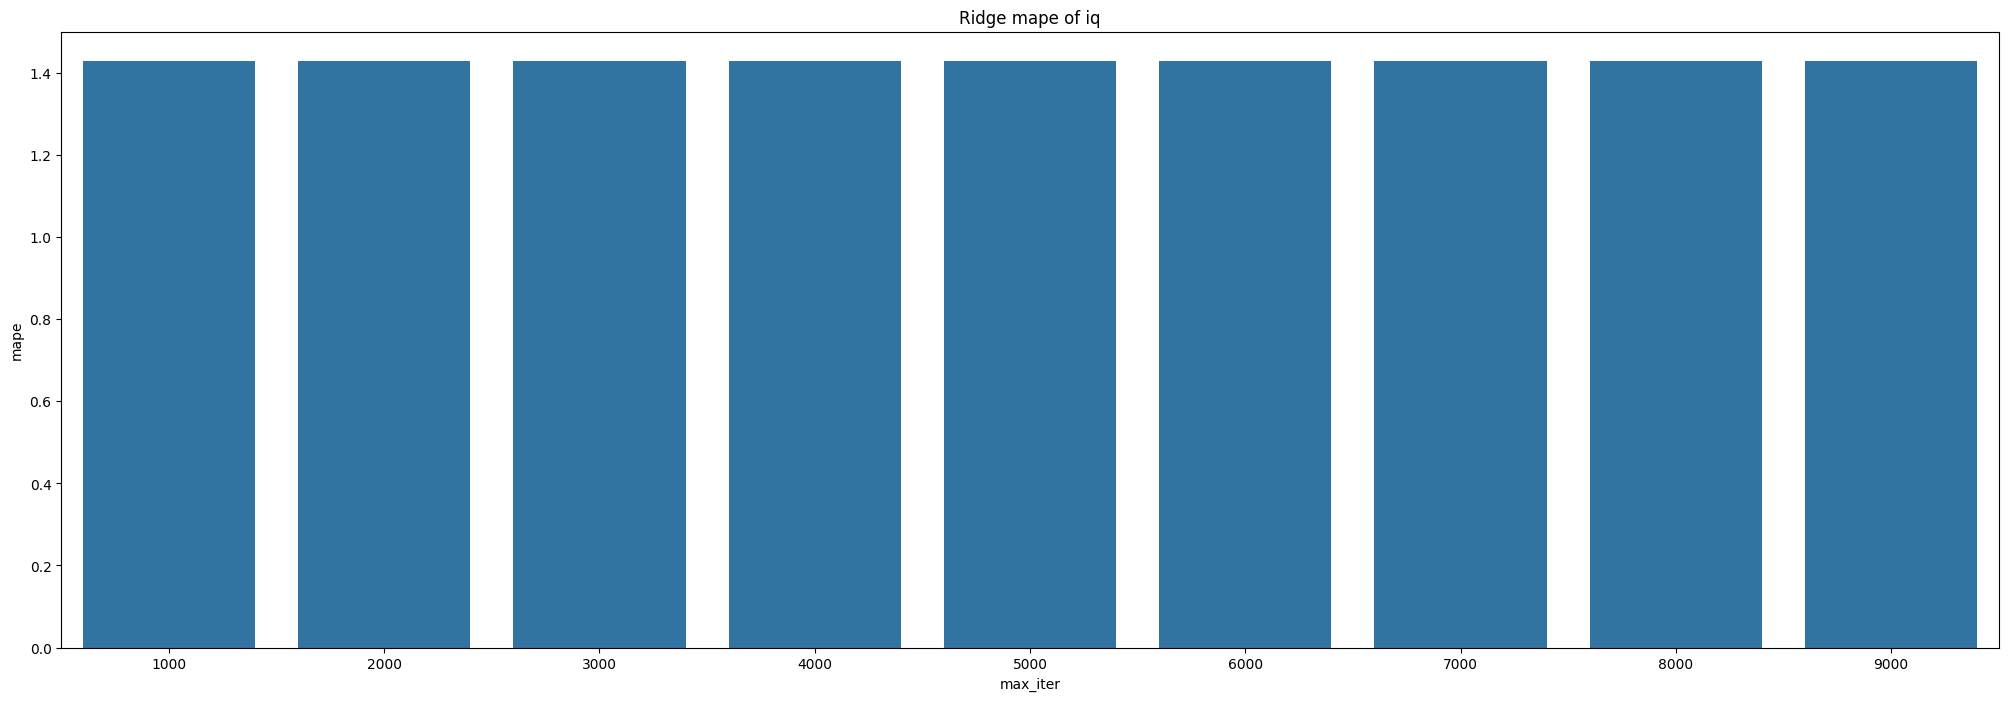

In [42]:
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in mapes],y=[i[1] for i in mapes])
plt.xlabel('max_iter')
plt.ylabel('mape')
plt.title('Ridge mape of iq')
plt.show()

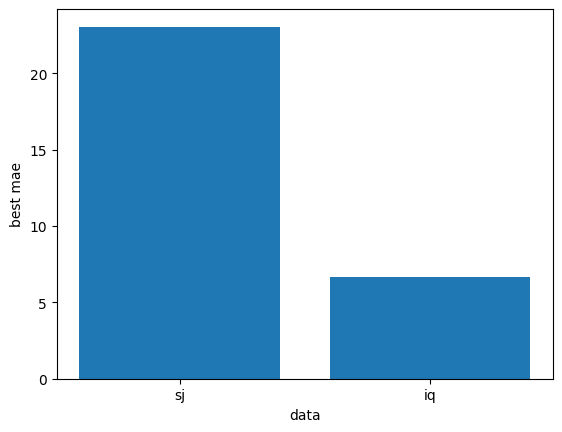

In [43]:
plt.bar(['sj','iq'],[best_sj_mae_ridge,best_iq_mae_ridge])
plt.xlabel('data')
plt.ylabel('best mae')
plt.show()

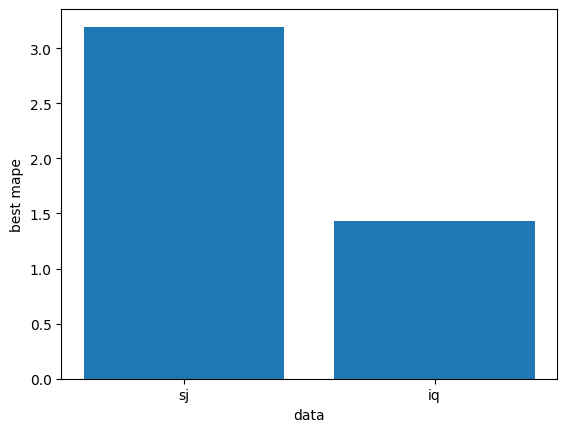

In [44]:
plt.bar(['sj','iq'],[best_sj_mape_ridge,best_iq_mape_ridge])
plt.xlabel('data')
plt.ylabel('best mape')
plt.show()